In [1]:
from pyspark.sql import SparkSession
from pandas import set_option

set_option('display.max.columns', None)

spark = SparkSession.builder.getOrCreate()

In [4]:
from pyspark.sql.functions import udf
from typing import Optional
import phonenumbers

@udf(returnType='string')
def parsePhoneNumber(number: Optional[str], region: str='US') -> Optional[str]:
    try:
        phoneNumber = phonenumbers.parse(number, region)
        return phonenumbers.format_number(phoneNumber, phonenumbers.PhoneNumberFormat.NATIONAL)
    except:
        return None
    
    
from pyspark.sql import Column
from pyspark.sql.functions import col, when

def matchPattern(colName: str, pattern: str) -> Column:
    column = col(colName) 
    return when(column.rlike(pattern), column)

In [3]:
activities = spark.read.parquet('/tmp/phone-calls/StatementRequestActivityRecords')
activities.limit(5).toPandas()

,ObjectID,CreatedDate,ReferenceNumber,CustomerVendorName,JobNumber,JobName,ContactType,ActivityUser,ActivityDate,FollowUpDate,STNID,Notes,Outcome,ActivityType,CustVendorObjectID,VendorContactObjectID,StatementRequestObjectID,CreatedBy,MessageID
0,42373858,2022-02-14 10:29:14.410,1204872,ONTARGETJOBS INC,3056,Sutter Health - 3056,None,Workflow Service,2022-02-14,NaT,NaN,None,Sent Authorization Letter,None,15863298,31446300,42372122,SVC_WORKFLOW,lo0kpojVRpK63Q0-tZt9FQ
1,42373853,2022-02-14 10:29:08.107,1281223,CARDIVA MEDICAL INC,3320,Dignity Health - 3320,None,Deborah Murphy,2022-02-14,NaT,NaN,None,None,None,26215461,29600706,36587007,DMURPHY,None
2,42373905,2022-02-14 10:30:21.083,1331383,"EDGE INFORMATION MANAGEMENT, INC.",4056,"Health First, Inc. - 4056",None,Jessica Rinehart,2022-02-14,NaT,NaN,None,None,None,42352516,42355958,42357889,JRINEHART,None
3,42374642,2022-02-14 10:43:59.057,1242775,FAVORITE NURSES FAVORITE TEMPS,3319,Catholic Health Initiatives - 3319,None,Deborah Murphy,2022-02-14,NaT,NaN,None,None,None,3490272,31401710,37795162,DMURPHY,None
4,42374788,2022-02-14 10:45:59.810,1324919,ARTHREX,4053,Hospital Sisters Health System - 4053,None,Dulce Reyes-Loredo,2022-02-14,NaT,NaN,None,None,None,41967124,41967126,41967127,DRLOREDO,None


In [6]:
vendors = spark.read.parquet('/tmp/phone-calls/VendorContacts')
vendors.limit(5).toPandas()

,CustVendorGroupNo,CustVendorNo,ContactType,TypePreferredContact,LastName,FirstName,FullName,Email,Phone,Fax,Title,Note,ExternalID,BSAPVCID,CID,CustomerName,CVObjectID,CustObjectID,ObjectID,CreatedDate,CreatedBy,BSAPVendorObjectID
0,52891,1192,Accounts Receivable,NaN,None,None,None,InvoiceInquiries@PremierInc.com,None,None,None,None,None,NaN,15249,Stanly Regional,412893,194771,1016896,2016-08-15 08:27:25.537,DKUESTER,1016896
1,50771,650,Accounts Receivable,NaN,None,None,None,Tabbie.Alvarado@henryschein.com,None,None,None,None,None,NaN,15249,Stanly Regional,408624,194771,1016899,2016-08-15 08:33:35.630,DKUESTER,1016899
2,53889,1521,Accounts Receivable,NaN,None,None,None,theracomar@icsconnect.com,(888) 882-9942,None,None,None,None,NaN,15249,Stanly Regional,414897,194771,1016843,2016-08-10 13:30:07.430,DKUESTER,1016843
3,80931,782,Accounts Receivable,NaN,Hanrahan,Lynne,Lynne Hanrahan,Lynne.hanrahan@esi.net,(757) 217-1381,None,Assistant Controller,None,None,NaN,2406,Sentara Healthcare,522962,515060,1017021,2016-08-24 11:01:55.053,DKUESTER,1017021
4,77228,103762,Accounts Receivable,NaN,None,None,None,scoleman@ajccpas.com,(804) 347-8839,None,None,None,None,NaN,2406,Sentara Healthcare,515472,515060,1017024,2016-08-24 11:04:54.023,DKUESTER,1017024


In [12]:
%%time
from pyspark.sql.functions import regexp_replace

pattern = r'\(\d+\) \d+-\d+' # (987) 654-3210

(
    vendors
    .select(
        'ObjectID',
        'CustomerName',
        'Phone'
    )
    .withColumn('Phone', regexp_replace('Phone', '^([^0-9]+)', ''))
    .withColumn('Phone', regexp_replace('Phone', '\s+(?=[^0-9])(.*)', ''))
    .withColumn('Phone', parsePhoneNumber('Phone'))
    .withColumn('Phone', matchPattern('Phone', pattern))
    # .sample(fraction=1e-2)
    # .show(truncate=False)
    .write
    .mode('overwrite')
    .parquet('/tmp/phone-calls/_vendors')
)


_vendors = spark.read.parquet('/tmp/phone-calls/_vendors')
_vendors.limit(5).toPandas()

CPU times: user 23.1 ms, sys: 5.83 ms, total: 28.9 ms
Wall time: 1min 5s


,ObjectID,CustomerName,Phone
0,1016896,Stanly Regional,None
1,1016899,Stanly Regional,None
2,1016843,Stanly Regional,(888) 882-9942
3,1017021,Sentara Healthcare,(757) 217-1381
4,1017024,Sentara Healthcare,(804) 347-8839


In [51]:
def cleanString(colName: str) -> Column:
    column = col(colName)
    column = lower(column)
    column = regexp_replace(column, '[^a-z0-9]', ' ')
    column = regexp_replace(column, r'\s+', ' ')
    return trim(column)

In [262]:
%%time
from pyspark.sql.functions import date_trunc, lit, lower, regexp_replace, split, trim, when
from pyspark.sql.functions import year, month, dayofmonth, hour, minute

case = when(
    col('ActivityType') == 'Called Vendor',
    lit('outbound')
).when(
    col('ActivityType') == 'Received Call / Email',
    lit('inbound')
)

(
    activities
    .where(col('ActivityType').isin('Called Vendor', 'Received Call / Email'))
    .select(
        col('ObjectID').alias('id'),
        date_trunc('second', 'CreatedDate').alias('CreatedDate'),
        'ActivityUser',
        'VendorContactObjectID',
        case.alias('direction')
    )
    .join(
        _vendors.drop('CustomerName'),
        on=activities['VendorContactObjectID'] == _vendors['ObjectID'],
        how='left' # inner
    )
    .withColumn('ActivityUser', cleanString('ActivityUser'))
    .withColumn('Phone', cleanString('Phone'))
    .withColumn('year', year('CreatedDate').cast('string'))
    .withColumn('month', month('CreatedDate').cast('string'))
    .withColumn('day', dayofmonth('CreatedDate').cast('string'))
    .withColumn('hour', hour('CreatedDate').cast('string'))
    # .withColumn('minute', minute('CreatedDate').cast('string'))
    .withColumn('prefix', split('Phone', r'\s')[0])
    .withColumn('main', split('Phone', r'\s')[1])
    .withColumn('suffix', split('Phone', r'\s')[2])
    .withColumn('CreatedDate', regexp_replace('CreatedDate', ':', '-'))
    .selectExpr(
        'id',
        'CreatedDate as datetime',
        # 'cast(CreatedDate as string) as datetime',
        'year',
        'month',
        'day',
        'hour',
        # 'minute',
        'ActivityUser as user',
        'prefix',
        'main',
        'suffix',
        'Phone as phone',
        'direction'
    )
    .write
    .mode('overwrite')
    .parquet('/tmp/phone-calls/_activities')
)

CPU times: user 25.9 ms, sys: 6.53 ms, total: 32.4 ms
Wall time: 6.94 s


In [178]:
_activities = spark.read.parquet('/tmp/phone-calls/_activities')

In [131]:
calls = spark.read.parquet('/tmp/phone-calls/AccountCallLogs')
calls.limit(5).toPandas()

,next_page_token,page_size,total_records,from,to,id,user_id,call_type,caller_number,caller_number_type,caller_name,caller_number_source,callee_number,caller_location,callee_number_type,callee_number_source,callee_location,callee_name,direction,duration,result,waiting_time,date_time,path,has_recording,charge,voice_mail_id,has_voicemail,rate,call_id,owner_type,owner_id,owner_name,owner_extension_number,caller_did_number,caller_country_code,caller_country_iso_code,callee_did_number,callee_country_code,callee_country_iso_code,answer_start_time,call_end_time
0,MNI3JNNEPEyFrnxeuneeLaoRqOrnm1XNOQ2,300,2530,2022-05-09,2022-05-12,34bfc3eb-7180-4c83-b61b-345d084f72b1,d9JiQ8qqTcCh6bfVo2YIYw,pstn,None,1,Nicole Thompson,None,(828) 737-7552,None,2,internal,"Newland, NC",None,outbound,0,Call Cancel,NaN,2022-05-11 19:36:35,pstn,False,NaN,None,False,NaN,7096626840318811841,user,d9JiQ8qqTcCh6bfVo2YIYw,Nicole Thompson,255,+16167290255,1,US,+18287377552,1,US,NaT,2022-05-11 19:38:41
1,MNI3JNNEPEyFrnxeuneeLaoRqOrnm1XNOQ2,300,2530,2022-05-09,2022-05-12,d3d79bc4-22cd-4936-9889-e10f815f45ba,None,voip,(616) 208-1843,2,Amerisave,internal,None,None,1,None,None,Main Auto Receptionist,inbound,0,No Answer,NaN,2022-05-11 19:28:25,autoReceptionist,False,NaN,None,False,NaN,7096624731490955678,autoReceptionist,fK99-uaJRnG8yW-b9B4-9g,Main Auto Receptionist,300,None,1,US,+16162576300,1,US,NaT,NaT
2,MNI3JNNEPEyFrnxeuneeLaoRqOrnm1XNOQ2,300,2530,2022-05-09,2022-05-12,2b8ca4c8-7adc-436a-a2b5-17b0aea69a20,None,voip,(516) 565-8083,2,None,internal,None,Garden City NY,1,None,None,Main Auto Receptionist,inbound,0,No Answer,NaN,2022-05-11 19:21:14,autoReceptionist,False,NaN,None,False,NaN,7096622880360005894,autoReceptionist,fK99-uaJRnG8yW-b9B4-9g,Main Auto Receptionist,300,None,1,US,+16162576300,1,US,NaT,NaT
3,MNI3JNNEPEyFrnxeuneeLaoRqOrnm1XNOQ2,300,2530,2022-05-09,2022-05-12,fbc302fc-4082-4cb5-bb06-f99b603f3392,1avZmyzLRzu2AInJp75T1Q,voip,(231) 265-6202,2,2312656202,internal,None,None,1,None,None,Jessica Osborn,inbound,0,No Answer,NaN,2022-05-11 19:00:02,pstn,False,NaN,None,False,NaN,7096617421447184140,user,1avZmyzLRzu2AInJp75T1Q,Jessica Osborn,226,None,1,US,+16162572026,1,US,NaT,NaT
4,MNI3JNNEPEyFrnxeuneeLaoRqOrnm1XNOQ2,300,2530,2022-05-09,2022-05-12,a0d06ee4-4472-40f6-a793-2edadca307f6,bkasEu6zRz2YKurlHXnIqw,voip,(702) 228-0222,2,RR Partners,internal,None,None,1,None,None,Jessica Caggiano,inbound,0,No Answer,NaN,2022-05-11 18:47:33,pstn,False,NaN,None,False,NaN,7096614200270916926,user,bkasEu6zRz2YKurlHXnIqw,Jessica Caggiano,208,None,1,US,+16162572008,1,US,NaT,NaT


In [76]:
calls.groupBy('path').count().show()

+----------------+-----+
|            path|count|
+----------------+-----+
|       extension|   30|
|autoReceptionist|   66|
|            pstn| 2432|
|       callQueue|    2|
+----------------+-----+



In [259]:
outbound = (
    calls
    .where(col('direction') == 'outbound')
    .select(
        'id',
        col('date_time').alias('datetime'),
        cleanString('caller_name').alias('user'),
        cleanString('callee_number').alias('phone'),
        'direction'
    )
    .withColumn('year', year('datetime').cast('string'))
    .withColumn('month', month('datetime').cast('string'))
    .withColumn('day', dayofmonth('datetime').cast('string'))
    .withColumn('hour', hour('datetime').cast('string'))
    # .withColumn('minute', minute('datetime').cast('string'))
    .withColumn('prefix', split('phone', r'\s')[0])
    .withColumn('main', split('phone', r'\s')[1])
    .withColumn('suffix', split('phone', r'\s')[2])
    .withColumn('datetime', regexp_replace('datetime', ':', '-'))
    .selectExpr(
        'id',
        'datetime',
        # 'cast(datetime as string) as datetime',
        'year',
        'month',
        'day',
        'hour',
        # 'minute',
        'user',
        'prefix',
        'main',
        'suffix',
        'phone',
        'direction'
    )
)

In [260]:
# Main Auto Receptionist

inbound = (
    calls
    .where(col('direction') == 'inbound')
    .where(col('path') != 'autoReceptionist')
    .select(
        'id',
        col('date_time').alias('datetime'),
        cleanString('callee_name').alias('user'),
        cleanString('caller_number').alias('phone'),
        'direction'
    )
    .withColumn('year', year('datetime').cast('string'))
    .withColumn('month', month('datetime').cast('string'))
    .withColumn('day', dayofmonth('datetime').cast('string'))
    .withColumn('hour', hour('datetime').cast('string'))
    # .withColumn('minute', minute('datetime').cast('string'))
    .withColumn('prefix', split('phone', r'\s')[0])
    .withColumn('main', split('phone', r'\s')[1])
    .withColumn('suffix', split('phone', r'\s')[2])
    .withColumn('datetime', regexp_replace('datetime', ':', '-'))
    .selectExpr(
        'id',
        'datetime',
        # 'cast(datetime as string) as datetime',
        'year',
        'month',
        'day',
        'hour',
        # 'minute',
        'user',
        'prefix',
        'main',
        'suffix',
        'phone',
        'direction'
    )
)

In [261]:
(
    outbound
    .union(inbound)
    .write
    .mode('overwrite')
    .parquet('/tmp/phone-calls/_calls')
)

In [308]:
bridge = spark.read.parquet('/tmp/phone-calls/outbound')
bridge.createOrReplaceTempView('bridge')
bridge.limit(5).toPandas()

# bridge.orderBy('_score').limit(5).toPandas()

,id,_id,_score
0,856cf725-829b-4fdb-869e-072f3b2f0a8c,47836268,12.113562
1,d7fa36b4-3cca-47cb-bbaf-9b0f79cdf709,47862579,10.309065
2,ddecf007-3c02-4395-9736-d2c9c7895c62,47830421,10.447012
3,62551586-bf89-4825-8d5b-7eec6ae4cd0d,47836652,13.105770
4,f3ebd4d7-899f-4132-b68b-48b10b5872ad,47833403,11.859122


In [280]:
bridge.count()

1338

In [264]:
activities.createOrReplaceTempView('activities')
_vendors.createOrReplaceTempView('vendors')
calls.createOrReplaceTempView('calls')

In [332]:
query = """
SELECT
    activities.ObjectID,
    calls.id,
    date_trunc('second', CreatedDate) as CreatedDate,
    calls.date_time,
    ActivityUser,
    calls.caller_name,
    ActivityType,
    calls.direction,
    vendors.Phone,
    calls.callee_number,
    CustomerName,
    bridge._score,
    calls.duration,
    abs(
        cast(CreatedDate as long)
        - cast(date_time as long)
    ) as difference
FROM
    activities
        LEFT JOIN
            vendors ON
                activities.VendorContactObjectID = vendors.ObjectID
        INNER JOIN
            bridge ON
                activities.ObjectID = bridge._id
        INNER JOIN
            calls ON
                bridge.id = calls.id
WHERE
    ActivityType = 'Called Vendor'
    AND callee_number IS NOT NULL
    AND abs(
        cast(CreatedDate as long)
        - cast(date_time as long)
    ) < 600
"""

(
    spark
    .sql(query)
    .sample(fraction=1e-2)
    .orderBy(desc('_score'))
    # .where('Phone != callee_number')
    # .where('callee_number is null')
    # .where('Phone is null')
    .orderBy('_score')
    .limit(10)
    .toPandas()
)
# spark.sql(query).count()

,ObjectID,id,CreatedDate,date_time,ActivityUser,caller_name,ActivityType,direction,Phone,callee_number,CustomerName,_score,duration,difference
0,47835735,692534d3-cc00-43a7-a852-92922400976c,2022-05-10 11:29:07,2022-05-10 11:27:39,Yodit Kahssai,Yodit Kahssai,Called Vendor,outbound,(877) 427-6842,(877) 427-6842,Atrium Health,11.104596,80,88
1,47861884,1cb6530d-5e83-466f-977d-106cc9bbe8ef,2022-05-11 14:36:32,2022-05-11 14:36:58,Josephine Dagher,Josephine Dagher,Called Vendor,outbound,(206) 225-4484,(206) 225-4484,Highmark Health,11.519353,74,26
2,47840177,69d7767f-8cba-4c75-b489-ab5cf7425295,2022-05-10 16:27:06,2022-05-10 16:25:01,Yodit Kahssai,Yodit Kahssai,Called Vendor,outbound,(617) 455-0600,(617) 455-0600,Atrium Health,11.677255,118,125
3,47772582,6cdd3ae3-3670-485d-9d8f-9dd0a834667e,2022-05-09 10:43:02,2022-05-09 10:48:54,Josephine Dagher,Josephine Dagher,Called Vendor,outbound,(614) 461-5881,(614) 461-5881,OhioHealth Corporation,11.878139,17,352
4,47767040,add925ce-945a-462b-a5dd-5d562745dc78,2022-05-09 08:39:40,2022-05-09 08:40:25,Cierra Kilpatrick,Cierra Kilpatrick,Called Vendor,outbound,(949) 282-2757,(949) 282-2757,Stanford,12.048547,11,45
5,47836123,2cae1e9c-5b7b-4dae-b261-1e06eefeb78c,2022-05-10 11:42:11,2022-05-10 11:40:54,Yodit Kahssai,Yodit Kahssai,Called Vendor,outbound,(816) 587-9555,(816) 587-9555,Atrium Health,12.096269,68,77
6,47859347,fd970509-df0a-4121-9bf3-0ab4f8c94452,2022-05-11 12:30:22,2022-05-11 12:30:47,Josephine Dagher,Josephine Dagher,Called Vendor,outbound,(717) 561-7782,(717) 561-7782,Highmark Health,12.439033,161,25
7,47768348,40d8406e-ba0e-4c72-a8f0-5a027eddcf67,2022-05-09 09:09:19,2022-05-09 09:07:50,Yodit Kahssai,Yodit Kahssai,Called Vendor,outbound,(301) 840-9331,(301) 840-9331,The Johns Hopkins Health System Corporation,12.449949,79,89
8,47854378,9db60492-9d1d-470f-82f3-65ba265dce78,2022-05-11 10:18:47,2022-05-11 10:17:14,Jamie Spurlock,Jamie Spurlock,Called Vendor,outbound,(210) 821-4105,(210) 821-4105,UC Irvine Medical Center,12.559536,82,93
9,47781529,c7f10d59-d564-44fc-a03b-0ed67eb120b4,2022-05-09 16:54:38,2022-05-09 16:54:41,Xavier Baron,Xavier Baron,Called Vendor,outbound,(919) 696-1220,(919) 696-1220,Duke University Health System,12.714059,49,3


In [343]:
query = """
SELECT
    activities.ObjectID,
    calls.id,
    date_trunc('second', CreatedDate) as CreatedDate,
    calls.date_time,
    ActivityUser,
    calls.caller_name,
    ActivityType,
    calls.direction,
    vendors.Phone,
    calls.callee_number,
    CustomerName,
    calls.duration,
    abs(
        cast(CreatedDate as long)
        - cast(date_time as long)
    ) as difference
FROM
    activities
        INNER JOIN
            vendors ON
                activities.VendorContactObjectID = vendors.ObjectID
        INNER JOIN
            calls ON
                ActivityUser = caller_name
                AND cast(CreatedDate as date) = cast(date_time as date)
                AND split(Phone, ' ')[0] = split(callee_number, ' ')[0]
                AND split(Phone, ' ')[1] = split(callee_number, ' ')[1]
WHERE
    ActivityType = 'Called Vendor'
"""

spark.sql(query).count()

1382

In [360]:
from pyspark.sql import Window
from pyspark.sql.functions import row_number

column = row_number().over(Window.partitionBy('id').orderBy('difference'))

(
    spark
    .sql(query)
    .withColumn('_row_number', column)
    .where('_row_number = 1')
    .drop('_row_number')
    .where('difference < 600')
    # .sample(fraction=1e-2)
    # .limit(10)
    # .toPandas()
    .groupBy('CustomerName')
    .count()
    .orderBy(desc('count'))
    .show(truncate=False)
    # .groupBy('id')
    # .count()
    # .orderBy(desc('count'))
    # .show()
)

+-------------------------------------------+-----+
|CustomerName                               |count|
+-------------------------------------------+-----+
|Envision Healthcare Corporation            |123  |
|Duke University Health System              |82   |
|Lehigh Valley Health Network               |69   |
|The Johns Hopkins Health System Corporation|67   |
|Atrium Health                              |66   |
|Allegheny Health Network                   |59   |
|PruittHealth                               |57   |
|Dignity Health                             |55   |
|Community Health Systems                   |53   |
|Detroit Medical Center                     |48   |
|Catholic Health Initiatives                |47   |
|Highmark Health                            |45   |
|Lucile Packard Childrens Hospital          |45   |
|Trinity Health Corporate                   |43   |
|Cambridge Health Alliance                  |38   |
|Wellforce-Tufts/MelroseWakefield           |37   |
|Sentara Hea

In [330]:
(
    spark
    .sql(query)
    .groupBy('caller_name')
    .count()
    .orderBy(desc('count'))
    .show()
)

+-----------------+-----+
|      caller_name|count|
+-----------------+-----+
|    Yodit Kahssai|  180|
|       Toni Engle|  147|
| Jessica Caggiano|  120|
|Cierra Kilpatrick|  115|
| Josephine Dagher|  114|
|   Deborah Murphy|  106|
|     Xavier Baron|   97|
|     Briana Louck|   84|
|     Kelly Fedele|   77|
|Chenoa Marklevitz|   64|
|      Carla Roark|   63|
|   Jamie Spurlock|   63|
|      Annie Lewis|   37|
|      Ashley Tran|   30|
|           J Boyd|   13|
|     Ashton Sower|    5|
|  Steven Williams|    4|
|      John Pauley|    2|
+-----------------+-----+



In [337]:
bridge.count()

1351

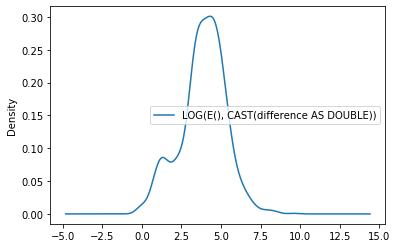

In [348]:
(
    spark
    .sql(query)
    .withColumn('_row_number', column)
    .where('_row_number = 1')
    .selectExpr('log(difference)')
    .toPandas()
    # .hist()
    .plot
    .density()
)

In [322]:
import math

math.e ** 8

2980.957987041727

In [244]:
outbound.where(col('id') == 'f3ebd4d7-899f-4132-b68b-48b10b5872ad').toPandas()

,id,datetime,user,prefix,main,suffix,phone,direction
0,f3ebd4d7-899f-4132-b68b-48b10b5872ad,2022-05-10 09-37-33,josephine dagher,404,382,7055,404 382 7055,outbound


In [176]:
# outbound.where(col('user') == 'j boyd').where(col('datetime').contains('2022-05-09')).toPandas()

In [152]:
# calls.where(col('id') == 'f18a27c2-9345-44d5-8d9d-25fc1be40f71').toPandas()

In [245]:
_activities.where(col('id') == '47833403').toPandas()

,id,datetime,user,prefix,main,suffix,phone,direction
0,47833403,2022-05-10 09-35-28,josephine dagher,404,382,7055,404 382 7055,outbound


In [240]:
# _activities.where(col('user') == 'jealisa boyd').where(col('datetime').contains('2022-05-09')).toPandas()

In [139]:
outbound.where(col('phone') == '888 744 6679').toPandas()

,id,datetime,year,month,day,hour,minute,user,prefix,main,suffix,phone,direction
0,8672b1b5-1601-4d94-8e06-c1cdab826613,2022-05-10 16:03:54,2022,5,10,16,3,deborah murphy,888,744,6679,888 744 6679,outbound
1,856cf725-829b-4fdb-869e-072f3b2f0a8c,2022-05-10 11:57:39,2022,5,10,11,57,deborah murphy,888,744,6679,888 744 6679,outbound


In [129]:
_activities.where(col('phone') == '888 744 6679').toPandas()

,id,datetime,year,month,day,hour,minute,user,prefix,main,suffix,phone,direction
0,37512138,2021-09-17 11:39:09,2021,9,17,11,39,alexander lee,888,744,6679,888 744 6679,outbound
1,47836268,2022-05-10 11:55:41,2022,5,10,11,55,deborah murphy,888,744,6679,888 744 6679,outbound


In [198]:
from pyspark.sql.functions import desc

(
    calls
    .where(col('direction') == 'outbound')
    .join(
        bridge,
        on='id',
        how='left_anti'
    )
    .groupBy('caller_name')
    .count()
    .orderBy(desc('count'))
    .show()
)

+------------------+-----+
|       caller_name|count|
+------------------+-----+
|  Michelle Regnier|  131|
|      Kelly Fedele|  100|
|   Nicole Thompson|   83|
|      Briana Louck|   27|
|        Toni Engle|   23|
|  Jessica Caggiano|   22|
|   LeAnne Hoekstra|   19|
|Brandon Lothschutz|   18|
|      Matt Langton|   15|
|        Tim Jacobs|   15|
|       Ashley Tran|   13|
|       Ashley Pell|   13|
|            J Boyd|   13|
|      Xavier Baron|    9|
|    Janay Woodward|    9|
|    Ashley Normand|    8|
|       Nathan Nofs|    7|
|    Marcus Malling|    7|
| Cierra Kilpatrick|    6|
|    Nick VanTuinen|    6|
+------------------+-----+
only showing top 20 rows



In [190]:
calls.where(col('caller_name') == 'Josephine Dagher').count()

155

In [201]:
activities.where(col('ActivityUser') == 'Josephine Dagher').count()

41828

In [204]:
(
    calls
    .where(col('direction') == 'outbound')
    .join(
        bridge,
        on='id',
        how='left_semi'
    )
    .where(col('caller_name') == 'Kelly Fedele')
    .orderBy('date_time')
    # .count()
    .limit(5)
    .toPandas()
)

,id,next_page_token,page_size,total_records,from,to,user_id,call_type,caller_number,caller_number_type,caller_name,caller_number_source,callee_number,caller_location,callee_number_type,callee_number_source,callee_location,callee_name,direction,duration,result,waiting_time,date_time,path,has_recording,charge,voice_mail_id,has_voicemail,rate,call_id,owner_type,owner_id,owner_name,owner_extension_number,caller_did_number,caller_country_code,caller_country_iso_code,callee_did_number,callee_country_code,callee_country_iso_code,answer_start_time,call_end_time
0,68172bda-a537-4fc6-9c9f-207b952aad1e,None,300,2530,2022-05-09,2022-05-12,G0UAf5n1RiiKiLntrJNUxQ,pstn,None,1,Kelly Fedele,None,(254) 756-6511,None,2,internal,"Waco, TX",None,outbound,1,Call connected,NaN,2022-05-09 08:46:34,pstn,False,NaN,None,False,NaN,7095717161950610258,user,G0UAf5n1RiiKiLntrJNUxQ,Kelly Fedele,752,+16163152752,1,US,+12547566511,1,US,NaT,2022-05-09 08:46:47
1,c73a123a-6692-479e-bcbb-7eed09ce2124,None,300,2530,2022-05-09,2022-05-12,G0UAf5n1RiiKiLntrJNUxQ,pstn,None,1,Kelly Fedele,None,(903) 833-5815,None,2,internal,Texas,None,outbound,28,Call connected,NaN,2022-05-09 08:52:16,pstn,False,NaN,None,False,NaN,7095718630829416641,user,G0UAf5n1RiiKiLntrJNUxQ,Kelly Fedele,752,+16163152752,1,US,+19038335815,1,US,NaT,2022-05-09 08:52:45
2,f77a7aeb-3f82-4613-b9e1-7d1b17e9248d,None,300,2530,2022-05-09,2022-05-12,G0UAf5n1RiiKiLntrJNUxQ,pstn,None,1,Kelly Fedele,None,(903) 833-5815,None,2,internal,Texas,None,outbound,23,Call connected,NaN,2022-05-09 08:52:49,pstn,False,NaN,None,False,NaN,7095718772563302496,user,G0UAf5n1RiiKiLntrJNUxQ,Kelly Fedele,752,+16163152752,1,US,+19038335815,1,US,NaT,2022-05-09 08:53:14
3,99d7d7d8-705f-4345-980b-471310970fd9,None,300,2530,2022-05-09,2022-05-12,G0UAf5n1RiiKiLntrJNUxQ,pstn,None,1,Kelly Fedele,None,(800) 679-7836,None,2,internal,United States,None,outbound,3,Call connected,NaN,2022-05-09 08:56:44,pstn,False,NaN,None,False,NaN,7095719781880653756,user,G0UAf5n1RiiKiLntrJNUxQ,Kelly Fedele,752,+16163152752,1,US,+18006797836,1,US,NaT,2022-05-09 08:56:53
4,02b4a1ac-5d37-4283-84ea-720f950daee7,None,300,2530,2022-05-09,2022-05-12,G0UAf5n1RiiKiLntrJNUxQ,pstn,None,1,Kelly Fedele,None,(888) 260-4242,None,2,internal,United States,None,outbound,91,Call connected,NaN,2022-05-09 09:08:14,pstn,False,NaN,None,False,NaN,7095722745408059194,user,G0UAf5n1RiiKiLntrJNUxQ,Kelly Fedele,752,+16163152752,1,US,+18882604242,1,US,NaT,2022-05-09 09:09:48


In [336]:
(
    calls
    .where(col('direction') == 'outbound')
    .withColumn('caller_date', col('date_time').cast('date'))
    .join(
        activities
            .where(col('ActivityType') == 'Called Vendor')
            .join(
                _vendors
                    .withColumnRenamed('Phone', 'callee_number')
                    .select('ObjectID', 'callee_number'),
                on=activities['VendorContactObjectID'] == _vendors['ObjectID'],
                how='left'
            )
            .withColumnRenamed('ActivityUser', 'caller_name')
            .withColumn('caller_date', col('CreatedDate').cast('date')),
        on=['caller_name', 'caller_date', 'callee_number'],
        how='left_semi'
    )
    .count()
    # .groupBy('caller_name', 'caller_date')
    # .count()
    # .orderBy(desc('count'))
    # .show()
)

1367

In [ ]:
(
    activities
        .join(
            _vendors
                .withColumnRenamed('VendorContactObjectID', 'ObjectID')
                .withColumnRenamed('Phone', 'callee_number')
                .select('ObjectID', 'callee_number'),
            on='ObjectID',
            how='inner'
        )
)

In [239]:
(
    activities
    # .where(col('ActivityType') == 'Called Vendor')
    # .where(col('ActivityUser') == 'Alexander Lee')
    .where(col('ActivityUser').contains('Tim'))
    .groupBy('ActivityUser')
    .count()
    .show()
)

+-------------+-----+
| ActivityUser|count|
+-------------+-----+
|Tim Kornoelje|84314|
+-------------+-----+



In [ ]:
spark.stop()